In [4]:
""" Unquote this if you want to run the experiment here"""
# import subprocess

# file_name = "cont_psych_simpler_.py"  # replace with your file name
# subprocess.run(["python", file_name])

CompletedProcess(args=['python', 'cont_psych_simpler_.py'], returncode=0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io

In [10]:
# load mat file
import scipy.io as sio
import os
import glob

# get latest file from data folder
directory_path = "data"  # replace with your directory path
files = glob.glob(f"{directory_path}/*")
latest_file = max(files, key=os.path.getctime)

mat_contents = sio.loadmat(latest_file)

## Or load a specific file
#mat_contents = sio.loadmat('data/omer_Pilot_continous_psych_2023-09-26_00h46.01.195.mat')
mat_contents=sio.loadmat('data/092708_continous_psych_2023-10-13_13h45.08.071.mat')
#mat_contents=sio.loadmat('data/bonnen_data.mat')

mat_contents.keys()
sigma=mat_contents['sigma']
#target=mat_contents['target'] # velocity of target motion for 1200 frames (20 seconds) and 30 trials
#response=mat_contents['response'] # velocity of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
target=mat_contents['blob_x'] # x position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
response=mat_contents['mouse_x'] # y position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
# blob_x=mat_contents['blob_x'] # x po    sition of target for trialNum200 frames (20 seconds) and 30 trials
# blob_y=mat_contents['blob_y'] # y position of target for trialNum200 frames (20 seconds) and 30 trials
# # get diff for velocity to find horizontal and vertical velocity
# blob_x_velocity=np.diff(blob_x)
# blob_y_velocity=np.diff(blob_y)
# mouse_x_velocity=np.diff(mouse_x)
# mouse_y_velocity=np.diff(mouse_y)e
nTrial=len(sigma.flatten())
nTrialPerBlock=5
nSigma=(nTrial-1)//nTrialPerBlock+1
nTrialPerSigma=nTrial//nSigma 
blob_widths=[11,13,17,21,25,29]

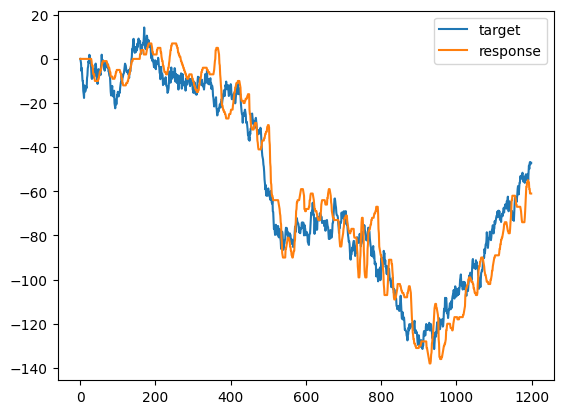

In [11]:
# plot the data
trialNum=0
plt.plot(target[trialNum,:])
plt.plot(response[trialNum,:])
plt.legend(['target','response'])
plt.show()


In [12]:
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(nTrial):
    #trial_dict[i] = {'target': target[i,:], 'response': response[i,:], 'mouse_x': mouse_x[i,:], 'mouse_y': mouse_y[i,:], 'blob_x': blob_x[i,:], 'blob_y': blob_y[i,:], 'sigma': sigma[0][i]}
    trial_dict[i]={'target': target[i,:], 'response': response[i,:], 'sigma': sigma[0][i]} #bonnen data


# for each trial remove fitst second(60 Frames) of the data
for i in range(nTrial):
    trial_dict[i]['target']=trial_dict[i]['target'][60:]
    trial_dict[i]['response']=trial_dict[i]['response'][60:]
    # trial_dict[i]['mouse_x']=trial_dict[i]['mouse_x'][60:]
    # trial_dict[i]['mouse_y']=trial_dict[i]['mouse_y'][60:]
    # trial_dict[i]['blob_x']=trial_dict[i]['blob_x'][60:]
    # trial_dict[i]['blob_y']=trial_dict[i]['blob_y'][60:]
    ##trial_dict[i]['sigma']=trial_dict[i]['sigma'][60:]

In [13]:

# sort the dictionary by sigma
trialDictSorted = sorted(trial_dict.items(), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[0][1]


# Cross Correlogram

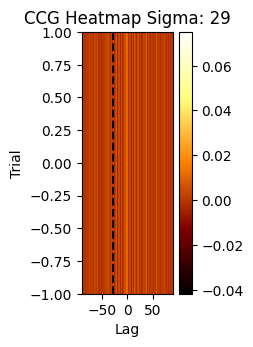

In [14]:
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=29
selected_sigma_ind=sigma_dict[selected_sigma]

tmp_trial=trialDictSorted[selected_sigma_ind*nTrialPerBlock+1][1]

# Normalize the signals
def min_max_normalizer(x):
    return ((x-x.min())/(x.max()-x.min()))*2-1
X=min_max_normalizer(tmp_trial['target'])
Y=min_max_normalizer(tmp_trial['response'])
ccg=  np.correlate(np.diff(X), np.diff(Y), 'full')
lag_range = 90
mid_point = len(ccg) // 2
ccg_range = ccg[mid_point - lag_range : mid_point+1 + lag_range]
# Create a time vector for the lag range
time_vector = np.arange(-lag_range, lag_range + 1)
# Create heatmap
plt.figure(figsize=(5,3.4))
plt.subplot(1, 3, 1)
plt.imshow([ccg], cmap='afmhot', aspect='auto', extent=[-lag_range, lag_range, -1, 1])
plt.title('CCG Heatmap Sigma: '+ str(selected_sigma))
plt.xlabel('Lag')
plt.ylabel('Trial')
plt.colorbar()
# Trace peak
peak_index = np.argmax(ccg_range) - lag_range
plt.axvline(peak_index, color='black', linestyle='--')


## Avarage CCG across different blob_widths

In [15]:
nTrialPerBlock

5

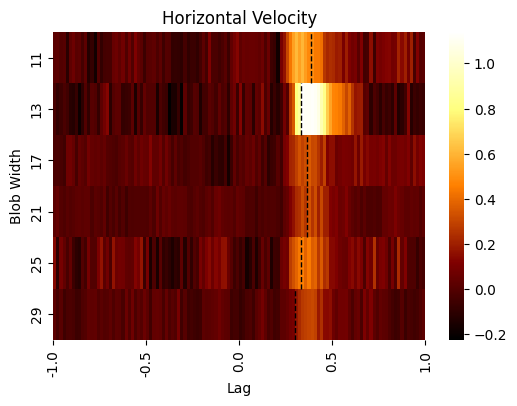

In [16]:
# avarage cross correlation for trials with the same sigma value
blob_widths=[11,13,17,21,25,29]
mean_ccgs=[]
ccg_blob_mean=[]
ccg_single_blob=[]
ccg_single_trials=[]
frameRate=60
lag_time=1 # seconds
lag_range = int(lag_time*frameRate)
len_trial=len(trialDictSorted[0][1]['target'])
mid_trial=int(len_trial/2)
for blob_width in range(len(blob_widths)):
    ccg_single_blobs=[]
    for i in range(nTrialPerSigma):
        tmp_trial=trialDictSorted[i+blob_width*nTrialPerSigma][1]
        #X=tmp_trial['mouse_x']
        X=tmp_trial['response'] # bonnen data
        #Y=tmp_trial['blob_x']
        Y=tmp_trial['target'] # bonnen data
        #X=(X-np.min(X))/(np.max(X)-np.min(X))*2-1        # normalize X
        # iinstad of normalizing take zscore
        X=(X-np.mean(X))/np.std(X)

        #Y=(Y-np.min(Y))/(np.max(Y)-np.min(Y))*2-1        # normalize Y
        Y= (Y-np.mean(Y))/np.std(Y)
        ccg_single_trial= np.correlate(np.diff(X), np.diff(Y), 'full')
        #ccg_single_trial = np.correlate(X, Y, 'full') # bonnen data
        ccg_single_trials.append(ccg_single_trial) 
        #ccg_single_trial = ccg_single_trial[len_trial - lag_range : len_trial + lag_range]
        ccg_single_blobs.append(ccg_single_trial)
    ccg_single_blob.append(ccg_single_blobs)
    ccg_blob_mean.append(np.mean(ccg_single_blob[blob_width], axis=0))

# Trim ccg_blob_mean to lag_range
ccg_blob_mean=np.array(ccg_blob_mean)
ccg_blob_mean_trimmed = ccg_blob_mean[:, len_trial - lag_range : len_trial + lag_range]
# trim single ccgs for each blob width
ccg_single_blob=np.array(ccg_single_blob)
ccg_single_blob_trimmed = ccg_single_blob[:, :, len_trial - lag_range: len_trial + lag_range]
# trim single ccgs for each trial
ccg_single_trials=np.array(ccg_single_trials)
ccg_single_trials_trimmed = ccg_single_trials[:, len_trial - lag_range: len_trial + lag_range]

# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot',yticklabels=blob_widths)

# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
#plt.imshow(ccg_blob_mean, cmap='afmhot', aspect='auto', yticklabels=blob_widths)
plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')

# Find lag indices of peaks in each row
peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
# Trace peak for each blob width
# Add peak lines to the heatmap
for i, peak_index in enumerate(peak_indices):
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/len(blob_widths), ymax=(i+1)/len(blob_widths))
plt.show()
#plt.colorbar()


In [17]:
ccg_single_blob[1][1].shape

(2277,)

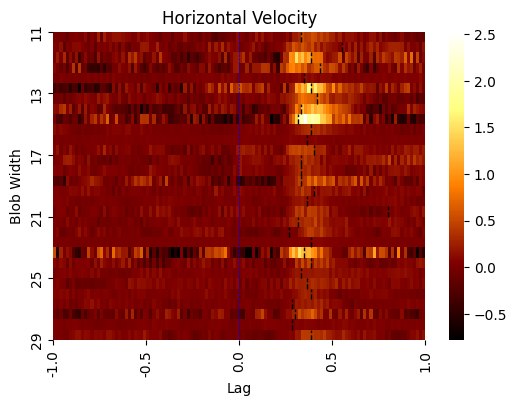

In [18]:
# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_single_trials_trimmed, cmap='afmhot')
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
## set y axis ticks based on blob widths so that each 5 rows are for the same blob width
yticks=np.linspace(0, len(ccg_single_trials_trimmed), 6)
yticklabels=blob_widths
plt.yticks(yticks, yticklabels)
plt.axvline(x=lag_range,color='blue',linestyle='--',linewidth=0.5)

plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')


# Trace peak for each blob width
peak_indices = np.argmax(ccg_single_trials_trimmed, axis=1)# Find lag indices of peaks in each row
# Add peak lines to the heatmap
for i, peak_index in enumerate(peak_indices):
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/nTrial, ymax=(i+1)/nTrial)
plt.show()


### CCG for single trial

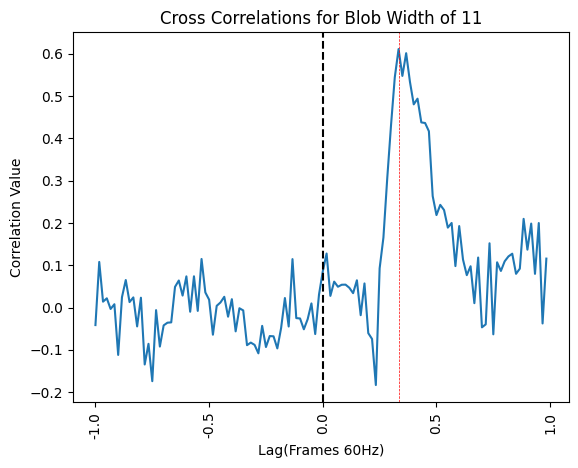

In [19]:
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=11
selected_sigma_ind=sigma_dict[selected_sigma]
# plot corss-correlation for a single trial
len_trial=len(trialDictSorted[0][1]['target'])
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)

ccg=ccg_blob_mean[selected_sigma_ind]# set CCG

mid_point=len(ccg)//2
plt.plot(ccg[mid_point-steps:mid_point+steps])
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*time_lag*2, 5)
labels=np.linspace(-time_lag, time_lag, len(x))
plt.xticks(x, labels, rotation='vertical')
#plot a vertical line at lag=0
plt.axvline(time_lag*frameRate, color='black', linestyle='--')
# calculate highest correlation
max_corr=np.max(ccg[mid_point-steps:mid_point+steps])
max_corr_index=np.argmax(ccg[mid_point-steps:mid_point+steps])
# plot the highest correlation
#plt.axhline(max_corr, color='black', linestyle='--')
#plt.plot(max_corr_index, max_corr, marker='o', markersize=3, color="red")
plt.axvline(max_corr_index, color='red', linestyle='--', linewidth=0.5)
plt.title('Cross Correlations for Blob Width of ' + str(trialDictSorted[selected_sigma_ind*nTrialPerSigma+1][1]['sigma']))
plt.xlabel('Lag(Frames 60Hz)')
plt.ylabel('Correlation Value')
plt.show()

## Avarage CCG plots 

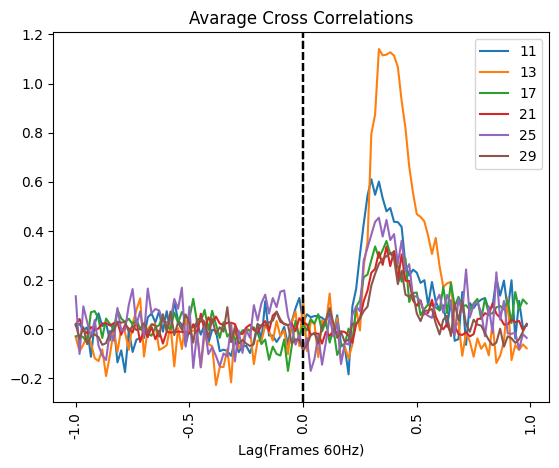

In [20]:
for i,bw in enumerate(blob_widths): 
   # plot corss-correlation for a single trial
    len_trial=len(trialDictSorted[0][1]['target'])
    frameRate=60
    time_lag=1 # seconds
    steps=int(frameRate*time_lag)
    # set CCG
    ccg=ccg_blob_mean[i]
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    # color based on bw
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw)
    plt.legend()
    # add bw as a label
    # set x axis ticks from -120 to 120 with ticks at every 20 units
    x=np.linspace(0, frameRate*time_lag*2, 5)
    labels=np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical')
    #plot a vertical line at lag=0
    plt.axvline(time_lag*frameRate, color='black', linestyle='--')
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    plt.title('Avarage Cross Correlations')
    plt.xlabel('Lag(Frames 60Hz)')
    #plt.show()



#### Fig 13: Gaussian fitting of CCG

In [21]:
def single_ccg_taker(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind][0]
    return ccg

def within_blob_ccgs(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind,:,:]
    ccgs_flat=ccg.flatten()
    return ccgs_flat

def single_trial_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    trial=trialDictSorted[blob_ind][1]
    return trial
def single_blob_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    blob=trialDictSorted[blob_ind:blob_ind+nTrialPerSigma]
    return blob

In [22]:
tmp_blob=single_blob_selector(sigma=11)
for i in range(nTrialPerSigma):
    target_positions=tmp_blob[i][1]['target']
    response_positions=tmp_blob[i][1]['response']
# Create a list of target positions
target_positions_list = [trial[1]['target'] for trial in tmp_blob]

# Convert the list to a numpy array
target_positions_matrix = np.array(target_positions_list)
target_positions_matrix.shape[0]

5

Text(0, 0.5, 'Cross Correlation')

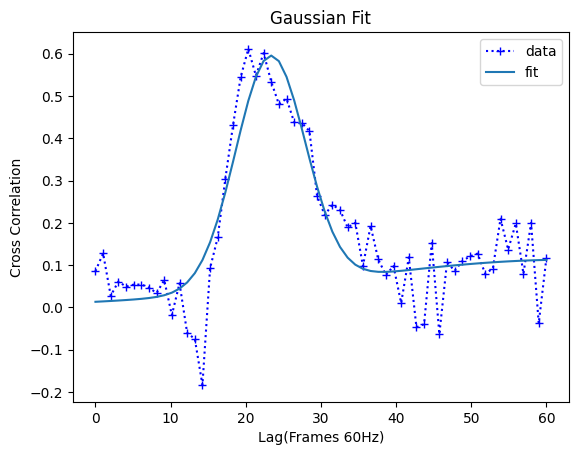

In [23]:
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
from scipy.optimize import curve_fit
import math

blob_ind=0
ccg=ccg_blob_mean[blob_ind]
mid_point = len(ccg) // 2
ydata=ccg[mid_point:mid_point+steps]
xdata= np.linspace(0, len(ydata), len(ydata))
# fit the ccg data with Gaussian
def gaussian(x,  beta, sigma):
    return 1/(sigma*np.sqrt(2*math.pi))*np.exp(-0.5*(((x-beta)**2)/(sigma**2)))

def double_gaussian(x, alpha1, beta1, sigma1, alpha2, beta2, sigma2):
    return alpha1 * np.exp(-(x - beta1) ** 2 / (2 * (sigma1 ** 2))) - alpha2 * np.exp(-(x - beta2) ** 2 / (2 * (sigma2 ** 2)))

plt.plot(xdata, ydata, 'b+:', label='data')
popt, pcov = curve_fit(double_gaussian, xdata, ydata,)
yFit=double_gaussian(xdata, *popt)

plt.plot(xdata, yFit, label='fit')
plt.legend()
plt.title('Gaussian Fit')
plt.xlabel('Lag(Frames 60Hz)')
plt.ylabel('Cross Correlation')


Text(0.5, 23.52222222222222, 'Blob Width')

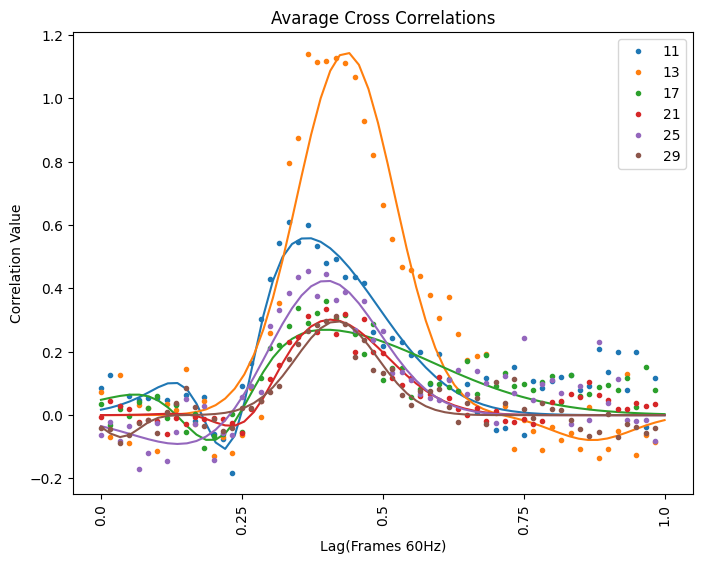

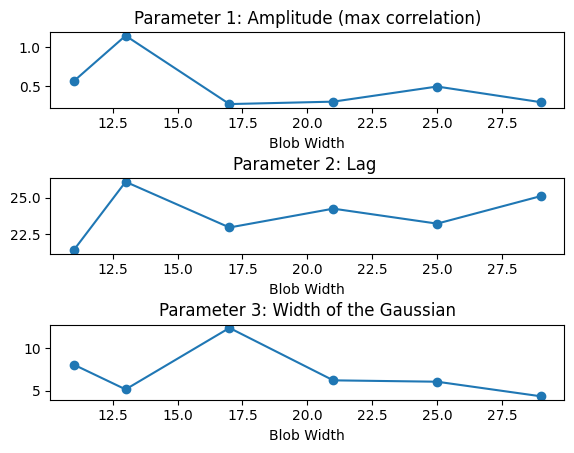

In [24]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
# plot avarage cross correlation for trials with the same sigma value
plt.figure(figsize=(8, 6))
popt_list=[]
pcov_list=[]
for i,bw in enumerate(blob_widths): 
# plot corss-correlation for a single trial
   color=np.random.rand(3,)   #random color selector

   len_trial=len(trialDictSorted[0][1]['target'])
   frameRate=60
   time_lag=1 # seconds
   steps=int(frameRate*time_lag)
   # set CCG
   ccg=ccg_blob_mean[i]
   mid_point = len(ccg) // 2
   # calculate highest correlation
   max_corr=np.max(ccg[mid_point:mid_point+steps])
   max_corr_index=np.argmax(ccg[mid_point:mid_point+steps])
   # color based on bw
   xdata= np.linspace(0, len(ydata), len(ydata))
   ydata=ccg[mid_point:mid_point+steps]

   # Set up the plot
   plt.plot(ccg[mid_point:mid_point+steps],'o', label=bw, markersize=3, color=colors[i])
   plt.legend()
   # set x axis ticks from 0 to 60 with ticks at every 20 units
   x=np.linspace(0, frameRate*time_lag, 5)
   labels=np.linspace(0, time_lag, len(x))
   plt.xticks(x, labels, rotation='vertical')
   plt.title('Avarage Cross Correlations')

   # calculate highest correlation
   max_corr=np.max(ccg[mid_point-steps:mid_point+steps])
   max_corr_index=np.argmax(ccg[mid_point-steps:mid_point+steps])
   """ Gaussian fit """
   ydata=ccg[mid_point:mid_point+steps]
   initial_guesses=[]
   initial_guesses.append(np.max(ydata))
   initial_guesses.append(np.argmax(ydata))
   initial_guesses.append(np.std(ydata)*10)
   initial_guesses.append(np.min(ydata))
   initial_guesses.append(np.argmin(ydata))
   initial_guesses.append(np.std(ydata)*10)

   popt, pcov = curve_fit(double_gaussian, xdata, ydata,p0=initial_guesses )
   yfit=double_gaussian(xdata, *popt)
   plt.plot(xdata, yfit,color=colors[i])

   plt.xlabel('Lag(Frames 60Hz)')
   plt.ylabel('Correlation Value')

   # save the parameters of the fit for each blob width
   popt_list.append(popt)
   pcov_list.append(pcov)


   #plt.show()

# Create 2x3 sub plots
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=3.0)
# Subplot 1: Plot the first parameter values for each blob width
axs[0].plot(blob_widths, [popt[0] for popt in popt_list], 'o-')
axs[0].set_title('Parameter 1: Amplitude (max correlation)')
axs[0].set_xlabel('Blob Width')
# Subplot 2: Plot the second parameter values for each blob width
axs[1].plot(blob_widths, [popt[1] for popt in popt_list], 'o-')
axs[1].set_title('Parameter 2: Lag ')
axs[1].set_xlabel('Blob Width')

# Subplot 3: Plot the third parameter values for each blob width
axs[2].plot(blob_widths, [popt[2] for popt in popt_list], 'o-')
axs[2].set_title('Parameter 3: Width of the Gaussian')
axs[2].set_xlabel('Blob Width')


## Kalman filter


In [25]:
import numpy as np
from scipy.sparse import diags

def myKalmanFast(x, Q, R):
    """ Kalman filter for position estimates.

    Args:
    x (numpy.ndarray): Target position.
    Q (float): Target displacement variance.
    R (float): Observation noise variance.
    
    Returns:
    xhat (numpy.ndarray): Position estimates.
    y (numpy.ndarray): Noisy sensory observations.
    K (float): Kalman gain.
    P (float): Posterior variance."""
    N = len(x)  # Number of samples
    v = np.random.randn(N) * np.sqrt(R)
    y = x + v  

    P = Q / 2 * (np.sqrt(1 + 4 * R / Q) - 1)  # Variance of posterior 
    K = (P + Q) / (P + Q + R)   #Kalman Gain
    
    # Create a sparse matrix for D 
    diagonals = [np.ones(N), (K - 1) * np.ones(N)]
    D = diags(diagonals, [0, -1], shape=(N, N)).toarray()
    
    xhat = np.linalg.solve(D, K * y) 
    
    return xhat, y, K, P


In [26]:
# Implementation
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
tmp_trial=single_trial_selector(sigma=11)
target_positions_x=tmp_trial['target']
response_positions_x=tmp_trial['response']

x = target_positions_x  # Replace target_positions with actual target position values

# Calculate displacements
displacements = np.diff(target_positions_x)
# Calculate variance of displacements
Q = np.var(displacements) # target displacement variance
# Set a reasonable value for observation noise variance R
R = 100 # or  np.var(target_positions_x - response_positions_x)

xhat, y_noisyObs, KalmanGain, posteriorVar = myKalmanFast(x, Q, R)

# calculate model error
error_xhat=target_positions_x-xhat
# calculate actual error
true_error_x=target_positions_x-response_positions_x

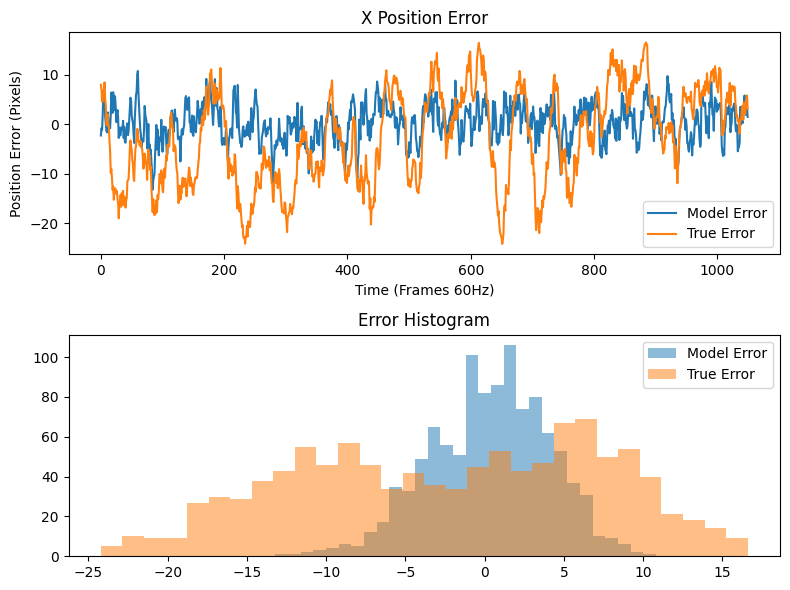

In [27]:
# Plot the position errors
plt.figure(figsize=(8, 6))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[90:], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Position Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[90:], label='True Error')
plt.legend()

# Create a plot to show the proportion of occurrences of each error value
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat[60:], bins=30, alpha=0.5)
plt.hist(true_error_x[60:], bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

## Negative Log Likelihood Uncertainty Estimates

Optimal value for observation noise variance is 2.832369830435774
Optimal value for observation noise variance is 2.5950195443329056
Optimal value for observation noise variance is 2.672896976317575
Optimal value for observation noise variance is 2.6797657954710066
Optimal value for observation noise variance is 2.540282270109291
Optimal value for observation noise variance is 2.6495989126729724


Text(0, 0.5, 'Positional Uncertainty (sqrt(R))')

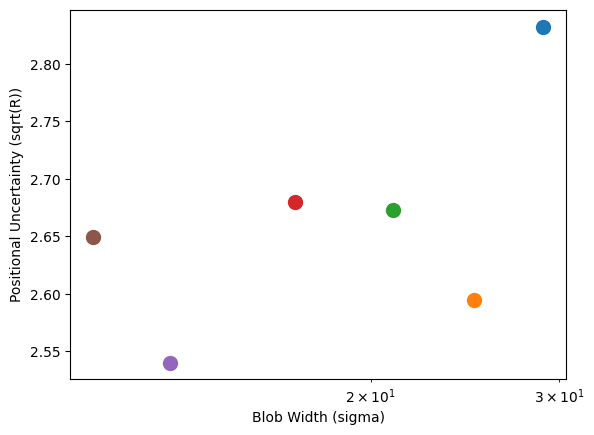

In [28]:
import numpy as np
from scipy.sparse import diags
import scipy.optimize as opt
#X = np.array(target_positions_list)
#Y = np.array(response_positions_list)
X=target
Y=response
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples
    nLL = 0

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    for i in range(numTrials):
        x = X[:, i]
        xhat = Xhat[:, i]
        temp = np.dot(d, xhat) - k * x  # eq B11
        nLL = nLL - (-1 / (2 * k**2 * rr) * np.dot(temp.T, temp) - N / 2 * np.log(rr) - N * np.log(k))

    return nLL
from scipy.optimize import minimize


nLLs = []
i=0
# Initialize arrays to store results
r_values = np.zeros(len(blob_widths))
fval_values = np.zeros(len(blob_widths))
# Plot setup
lag=12
clip=60
# Set the starting point to zero
#X = X - X[:, 0][:, np.newaxis]
#Y = Y - Y[:, 0][:, np.newaxis]

Xc = X[:, clip:X.shape[1]-lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]

Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
results=[]
Q=1
# calculate intirial Guess for Q 

rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
# sigmas is reversed unique values of sigma
sigmas = np.unique(sigma)[::-1]
for i in range(len(sigmas)):
    index = [s == sigmas[i] for s in sigma]
    index=np.array(index).flatten()
    #calculate Q for each sigma as a variance of displacement
    #Q = np.var(X[index,:].T)
    result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
    results.append(result)
    # # Store optimization results
    r_values[i] = np.sqrt(result.x[0])
    fval_values[i] = result.fun
    # print('Optimization for blob width of ' + str(sigmas) + ' is done!')
    print('Optimal value for observation noise variance is ' + str(r_values[i]))
    # #print('Optimal negative log-likelihood value is ' + str(fval_values[index]))
    # # Plot the result
    plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=20, label=f'sigma={sigmas}')
plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')



# Custom Kalman

Filtered Positions: [20.52963455 21.69259042 22.36591162 ... 35.02458439 35.01941231
 34.83584479]


Text(0.5, 1.0, 'Error Histogram')

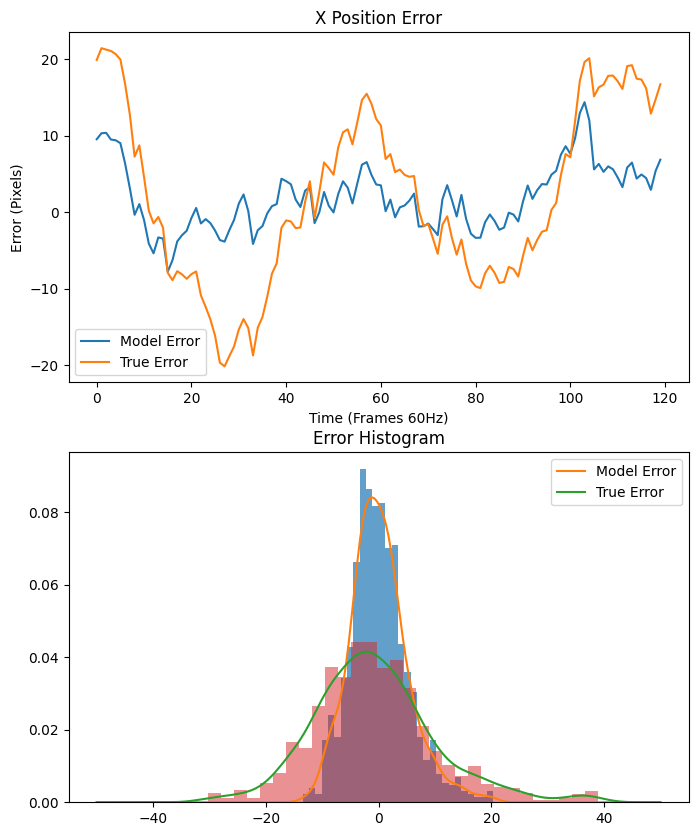

In [32]:
def kalman_filter2(observed_positions, initial_estimate, initial_error, process_variance, measurement_variance):
    """
    Kalman filter implementation for 1D position estimation.

    Parameters:
        observed_positions (list or numpy array): List of observed target positions.
        initial_estimate (float): Initial estimate of the target position.
        initial_error (float): Initial estimation error.
        process_variance (float): Process noise variance (how much the actual position can change over time).
        measurement_variance (float): Measurement noise variance (how noisy the observations are).

    Returns:
        filtered_positions (numpy array): Estimated target positions after applying the Kalman filter.
    """
    # Initialize variables
    estimate = initial_estimate
    error = initial_error

    # Kalman filter loop
    filtered_positions = []
    for observation in observed_positions:
        # Prediction step
        prediction = estimate
        prediction_error = error + process_variance

        # Update step
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        estimate = prediction + kalman_gain * (observation - prediction)
        error = (1 - kalman_gain) * prediction_error

        # Save the filtered estimate
        filtered_positions.append(estimate)

    return np.array(filtered_positions)


# Example implementation
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=13
selected_sigma_ind=sigma_dict[selected_sigma]
tmp_trial=trialDictSorted[selected_sigma_ind*5+1][1]
# Target information
target_positions_x=tmp_trial['target']
response_positions_x=tmp_trial['response']
# calculate actual error
true_error_x=target_positions_x-response_positions_x

# Example usage:
observed_positions= target_positions_x
initial_estimate = response_positions_x[0]#10.0  # Initial estimate of the target position
initial_error =true_error_x[0]# 10.0  # Initial estimation error
process_variance = 0.1  # Process noise variance
measurement_variance = 20  # Measurement noise variance
filtered_positions = kalman_filter2(observed_positions, initial_estimate, initial_error, process_variance, measurement_variance)
print("Filtered Positions:", filtered_positions)

# Plot the position errors
# calculate model error
error_xhat = target_positions_x - filtered_positions
# Plot error for 1.5 seconds
plt.figure(figsize=(8, 10))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[60*3:int(60*(3+2))], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[60*3:int((60*(3+2)))], label='True Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
plt.legend()

# plot the histogram of errors
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat, density=True, bins=30, alpha=0.7)
# density of error xhat
from scipy.stats import gaussian_kde
density_xhat = gaussian_kde(error_xhat)
xs = np.linspace(-50, 50, 200)
density_xhat.covariance_factor = lambda : .25
density_xhat._compute_covariance()
plt.plot(xs,density_xhat(xs))
# density of true error
density_true_error = gaussian_kde(true_error_x)
xs = np.linspace(-50, 50, 200)
density_true_error.covariance_factor = lambda : .25
density_true_error._compute_covariance()
plt.plot(xs,density_true_error(xs))
plt.legend(['Model Error', 'True Error'])

plt.hist(true_error_x,density=True, bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')


### Fit data

Text(0.5, 1.0, 'Error Histogram')

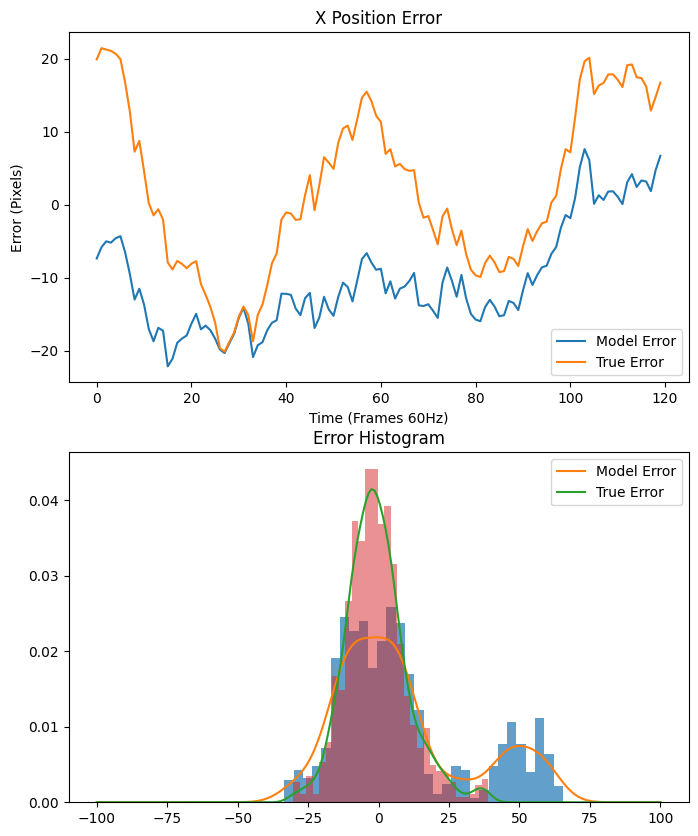

In [33]:
from scipy.optimize import curve_fit
# Initial parameter guesses
initial_estimate_guess = 10.0
initial_error_guess = 1.0
process_variance_guess = 0.1
measurement_variance_guess = 0.5
# Fit the Kalman filter parameters to the observed data
params, covariance = curve_fit(kalman_filter2, np.arange(len(observed_positions)),
                                observed_positions, p0=[initial_estimate_guess, initial_error_guess,
                                                         process_variance_guess, measurement_variance_guess])

# Extract the best-fitting parameters
best_initial_estimate, best_initial_error, best_process_variance, best_measurement_variance = params
# calculate model estimations using the best parameters

filtered_positions=kalman_filter2(observed_positions, best_initial_estimate, best_initial_error, best_process_variance, best_measurement_variance)


# Plot the position errors
# calculate model error
error_xhat = target_positions_x - filtered_positions
# Plot error for 1.5 seconds
plt.figure(figsize=(8, 10
))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[60*3:int(60*(3+2))], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[60*3:int((60*(3+2)))], label='True Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
plt.legend()

# plot the histogram of errors
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat, bins=30,density=True, alpha=0.7)
# density of error xhat
from scipy.stats import gaussian_kde
density_xhat = gaussian_kde(error_xhat)
xs = np.linspace(-100, 100, 200)
density_xhat.covariance_factor = lambda : .25
density_xhat._compute_covariance()
plt.plot(xs,density_xhat(xs))
# density of true error
density_true_error = gaussian_kde(true_error_x)
xs = np.linspace(-100, 100, 200)
density_true_error.covariance_factor = lambda : .25
density_true_error._compute_covariance()
plt.plot(xs,density_true_error(xs))
plt.legend(['Model Error', 'True Error'])

plt.hist(true_error_x,density=True, bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')


#